In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("final_merge.csv") #import dataframe
df['album_release'] = df['album_release'].fillna(0).astype(int) #must fill nan with value to convert to int
df = df.loc[df['year'] != 0] #don't take 0, as it means unknown
df.describe()

Unnamed: 0  song_hotttnesss  artist_latitude  artist_longitude  \
count  5.203790e+05    349099.000000    188960.000000     188960.000000   
mean   5.032707e+05         0.431690        39.934698        -54.412027   
std    2.908924e+05         0.214983        15.701568         56.035174   
min    0.000000e+00         0.000000       -51.800580       -159.540540   
25%    2.511270e+05         0.304170        35.149680        -90.180490   
50%    5.030970e+05         0.459725        40.714550        -75.162370   
75%    7.548480e+05         0.582811        50.848380         -1.546580   
max    1.007806e+06         1.000000        70.695760        178.690960   

          loudness_x         mode_x        tempo_x          key_x  \
count  520379.000000  520379.000000  520379.000000  520379.000000   
mean       -9.693092       0.663566     124.785756       5.315261   
std         4.938521       0.472490      34.854771       3.600813   
min       -57.004000       0.000000       0.000000       0.000000   
25%       -12.167000       0.000000      99.002000       2.000000   
50%        -8.608000       1.000000     122.486000       5.000000   
75%        -6.124000       1.000000     145.256500       9.000000   
max         4.150000       1.000000     280.955000      11.000000   

       genre2_cd2c       duration      ...          mode_y    speechiness  \
count          0.0  520379.000000      ...        146243.0  219885.000000   
mean           NaN     246.792014      ...             1.0       0.082549   
std            NaN     115.333437      ...             0.0       0.110330   
min            NaN       0.313020      ...             1.0       0.021600   
25%            NaN     183.196280      ...             1.0       0.034400   
50%            NaN     229.929340      ...             1.0       0.045700   
75%            NaN     286.980770      ...             1.0       0.077400   
max            NaN    3024.665670      ...             1.0       0.969000   

        acousticness  instrumentalness       liveness        valence  \
count  219942.000000     175752.000000  219979.000000  219876.000000   
mean        0.283646          0.254747       0.224016       0.488946   
std         0.327752          0.350219       0.203055       0.262209   
min         0.000001          0.000001       0.008600       0.000010   
25%         0.007250          0.000175       0.097400       0.273000   
50%         0.116000          0.016000       0.136000       0.486000   
75%         0.538000          0.573000       0.292000       0.703000   
max         0.996000          0.999000       1.000000       1.000000   

             tempo_y   duration_ms  track_popularity  album_release  
count  219885.000000  2.199850e+05     219841.000000  520379.000000  
mean      121.642483  2.394201e+05          4.899527     845.338449  
std        29.419634  1.043991e+05          8.608010     988.505496  
min        30.716000  4.000000e+03          0.000000       0.000000  
25%        98.943000  1.822930e+05          0.000000       0.000000  
50%       120.099000  2.274670e+05          0.000000       0.000000  
75%       139.709000  2.793070e+05          6.000000    2002.000000  
max       246.830000  3.005613e+06         73.000000    2016.000000  

[8 rows x 26 columns]

We can see that we still have more than 500k tracks to do our year/time analysis, which should be enough to see correlations if there are any.

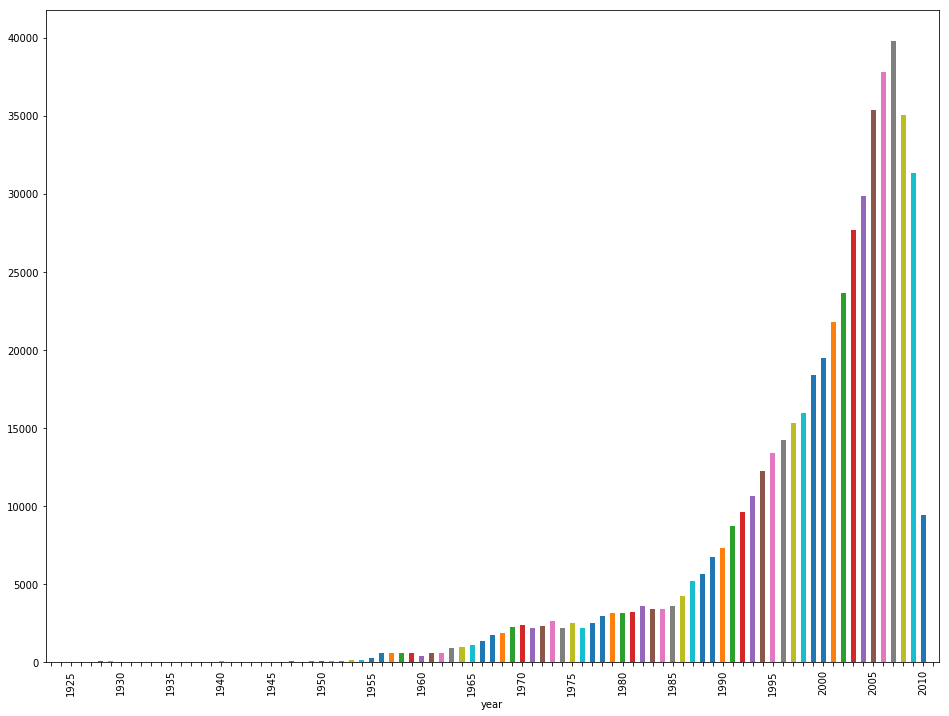

In [3]:
df_c = df.copy()

year_plot = df_c.groupby('year').size().plot(kind='bar', figsize=(16,12))
ax = plt.gca()
for label in ax.get_xticklabels(): #Little trick to avoid cluttering the x axis and only see every 5 years
    label.set_visible(False)
for label in ax.get_xticklabels()[2::5]:
    label.set_visible(True)

## Analysis

We can see, as expected, that the dataset doesn't have many songs before ~1990. It also stops after 2010 (when the dataset got created). The set is therefore not sampled uniformly on the release date. Indeed, as explained on the MSD website, the dataset was chosen using the most popular artist / tracks, which explains why older songs are underrepresented.

In [4]:
def plot_by(df, idx, column, ax=None):
    '''
        Plot a column (y axis) against an index (x axis)
        Will generate a plot matching for each idx value the mean of the column value for this idx.
        :param df: The dataframe containing the data
        :param idx: The x axis series
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    df_c.groupby([idx]).mean().plot(ax=ax)
    
def plot_by_year(df, column, ax = None):
    '''
        Plot a column (y axis) against the year (x axis)
        Will generate a plot matching for each year the mean of the column value for this year.
        :param df: The dataframe containing the data
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_by(df,'year',column, ax=ax)
    
def plot_heatmap_by(df, idx, column, ax = None):
    '''
        Plot a heatmap using an index (x axis), and a column (y axis)
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param idx: the name of the x axis series
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if df[column].dtype == np.float or df[column].dtype == np.float64: #Bin the data if needed
        bins = np.linspace(df[column].min(),df[column].max(),20)
        df_c[column] = pd.cut(df_c[column],bins)
    df_c = df_c.dropna()
    df_count = pd.DataFrame(df_c.groupby([idx, column]).size().rename('count'))
    df_c = df_c.join(df_count, on=[idx,column])
    df_c = df_c.reset_index().pivot_table(index=idx, columns=column, values='count', aggfunc='mean')
    if ax==None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    sns.heatmap(df_c, ax=ax, cbar_kws={'label': 'Number of samples'})

def plot_heatmap_by_year(df, column, ax=None):
    '''
        Plot a heatmap using a column (y axis) against the years
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_heatmap_by(df, 'year', column, ax=ax)
    
def plot_for_year(df, column, year, ax=None):
    '''
        Plot a stripplot (lineplot) of a feature / column for a given year
        The plot will have jitter to better visualize the data
        :param df: The dataframe containing the data
        :param column: the name of the series
        :param year: the year
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type year: int
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[df_c['year']==year]
    df_c = df_c[[column]]
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(column)
    axes.set_ylabel(year)
    sns.stripplot(df_c, jitter=0.4, ax=axes)
    
def plot_heatmap_for_year(df, column1, column2, year, ax=None):
    '''
        Plot a kdeplot of two features / columns for a given year
        It will allow to see correlation between the two columns
        :param df: The dataframe containing the data
        :param column1: the name of the first series
        :param column2: the name of the second series
        :param year: the year
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column1: string
        :type column2: string
        :type year: int
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[df_c['year']==year]
    df_c = df_c[[column1, column2]]
    df_c = df_c.dropna()
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(column1)
    axes.set_ylabel(column2)
    sns.kdeplot(df_c[column1], df_c[column2], cmap="Reds", shade=True, shade_lowest=False, ax=axes)
    
def plot_corr(df):
    '''
        Plot the correlation matrix of a dataframe
        The plot will be triangular with negative values blue and positive values red
        Code taken from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        :param df: The dataframe
        :type df: DataFrame
    '''
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))
    f.suptitle("Correlation heatmap")

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def ceil(x):
    '''
        Shortcut for np.ceil(x).astype(int)
        :param x: the value to ceil
        :type x: number
        :return: The result of the ceiling as an int
        :rtype: int
    '''
    return np.ceil(x).astype(int)

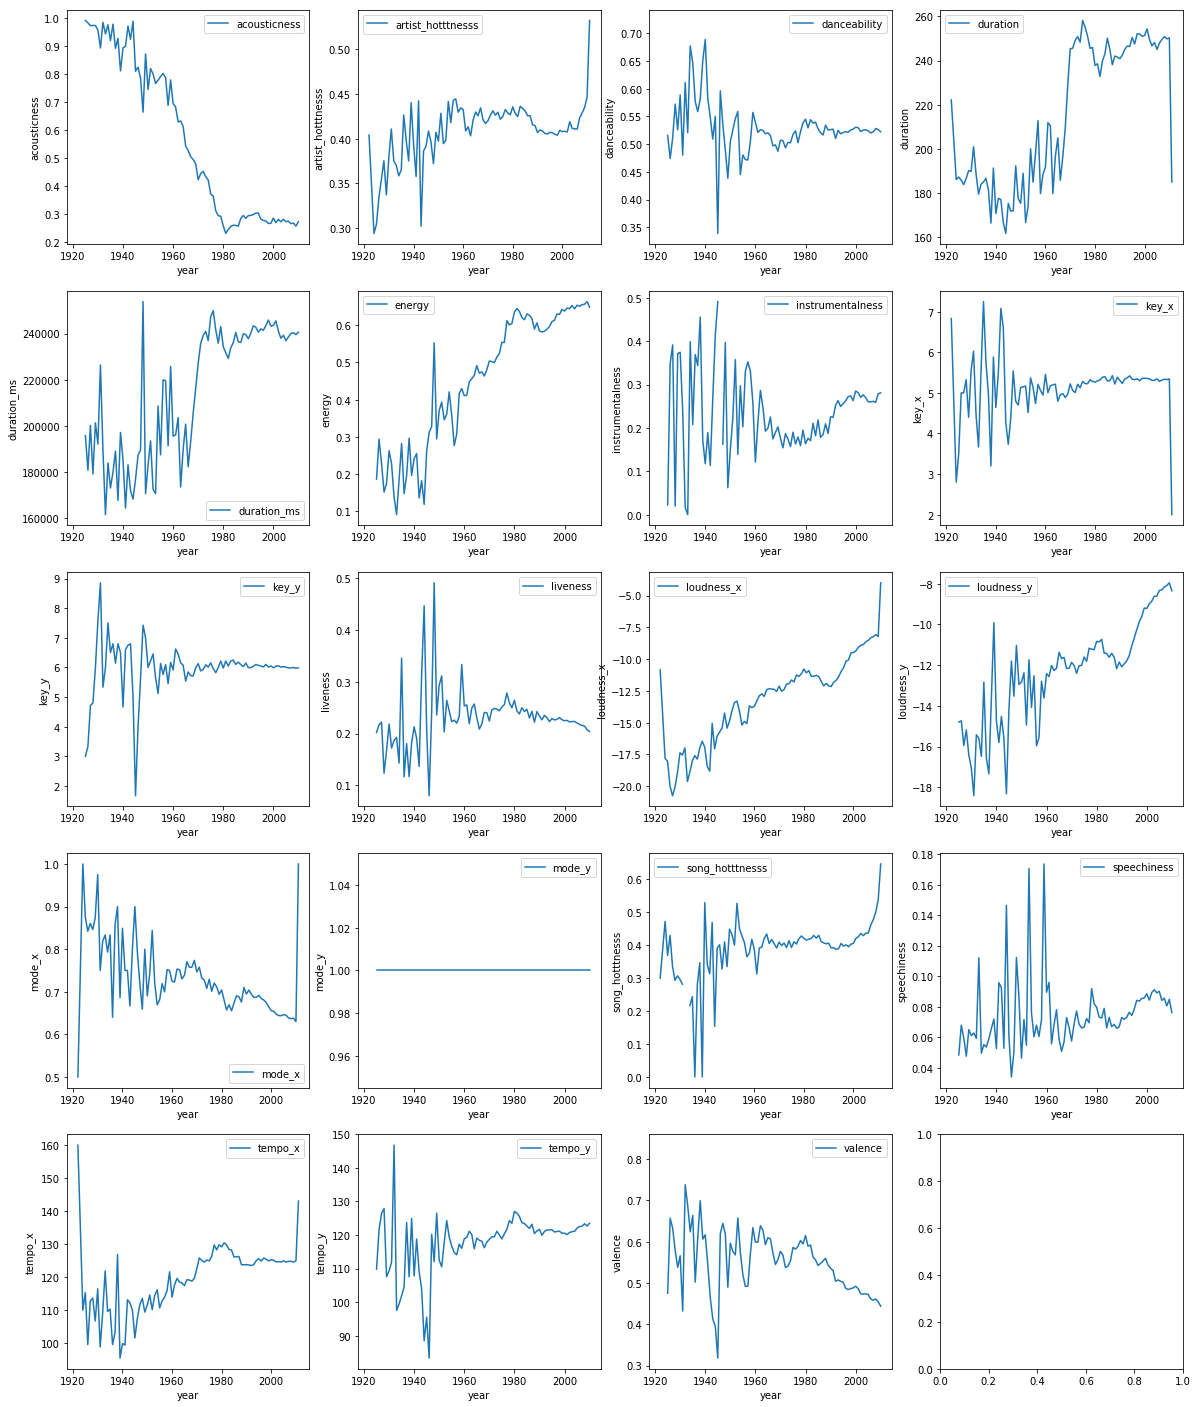

In [5]:
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
selected.sort()

n_cols = 4
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols)
idx_r = 0
idx_c = 0

#For each feature, plot the mean of the feature for each year
for col in selected:
    plot_by_year(df,col,ax=ax[idx_r, idx_c])
    if idx_c==n_cols-1:
        idx_r+=1
        idx_c=0
    else:
        idx_c+=1

## Analysis

For most of the data before ~1960, there is a huge variance due to the low number of samples. However, we can still see tendencies for several features.    
- Duration : We can see a clear spike (for both duration and duration_ms) around 1960. We suppose that it is due to the apparition and democratization of the vinyl record (more precisely its more modern iteration). This allowed the musicians to store longer musics (which seemed to be a problem before). However, the duration hasn't increased since, probably because the artists and public feel that the current mean duration is the most optimal one.

- Acousticness : We see a massive drop through the years. This is surely due to the apparition of the electronic music (acousticness is determined by the absence of electronic instruments).

- Loudness : The music seems to get louder and louder. This is probably due to cultural changes (genre, etc).

- Energy : The energy also increases along with the loudness.

- Song hotness : The hotness seems to spike at around 2010. This may be explained by the algorithm, if it is similar to the one of Spotify, the hotness is hugely influenced by the recency of the music, which explains this result. Otherwise, this may be due to the same problem seen with tempo, mode, etc, which all spike at the end of the graph.

- We can drop mode_y, as it is always 1.

- We can't really say much about the other values, except that they seem to stay stable through the years.

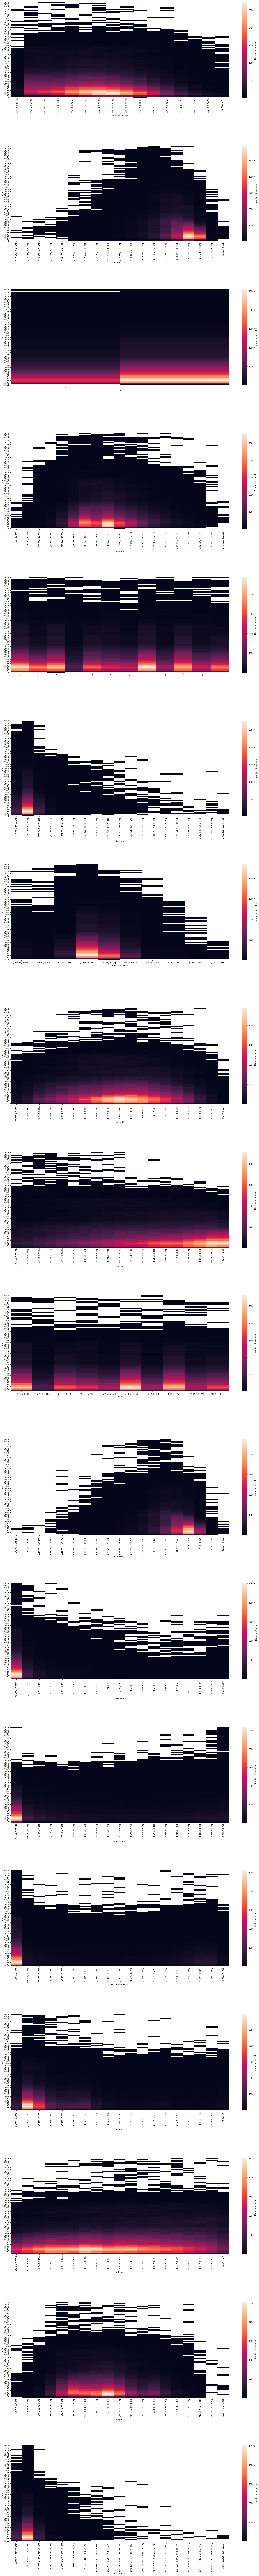

In [6]:
n_cols = 1
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols/2) #Trying to find a good aspect
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

#For each feature, print the heatmap of the feature regarding the year
for idx,col in enumerate(selected):
    plot_heatmap_by_year(df, col, ax=ax[idx])

## Analysis
These graphs don't show much, except that most of the samples are recent, as seen earlier (and what feature values those recent years samples have). We could perhaps normalize by year to have a better visualization.

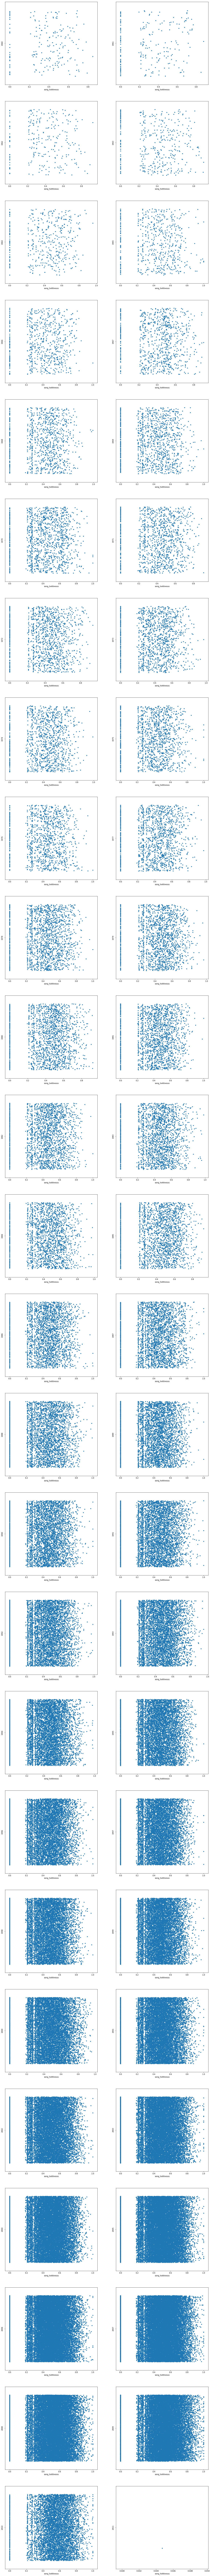

In [7]:
n_cols = 2
year_r = range(1960,2012)
n_rows = np.ceil(len(year_r)/n_cols).astype(int)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows/n_cols*20)
idx_r = 0
idx_c = 0

#Plot the song hotness distribution for each year
for year in year_r:
    plot_for_year(df,'song_hotttnesss',year,ax=ax[idx_r, idx_c])
    if idx_c==n_cols-1:
        idx_r+=1
        idx_c=0
    else:
        idx_c+=1

## Analysis example

The first thing we remark is that a lot of the samples have an hotness of 0. We wondered if this means that the song hasn't been rated, but the description of the dataset just says that the hotness goes from 0 to 1, thus it seems that those songs are just really unpopular (which seems plausible).

We can see that, although the number of samples drastically increases as time goes on, the distribution roughly stays the same (which we could see in the previous graphs). We can also distinguish what looks like lines around 0.2, 0.27, 0.3 mainly (which means an higher concentration of samples). We don't know if it is due to the algorithm used for the rating or if this is just a coincidence at the moment.

## Milestone 3

- We'll probably discard the data before ~1960, as there are so few samples.
- We'll create an animation for each feature and year to visualize their evolution through time.    
- We'll group the years in decades (for example) to visualize better the differences (as we always speak about the 80s, 90s etc music)
- We'll look further into each feature to see if we can conclude anything regarding the correlation between the features and the hotness.    